# Machine learning project: Prediction race preformance from practice data

### Importing libraries 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, GroupKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import svm
from sklearn.linear_model import Lasso, Ridge, ElasticNet

### For reproducibility

In [2]:
r_seed = np.random.seed(18) #My lucky number

### Collect data

In [ ]:
data = pd.read_csv('F1_data.csv')

## Task 1: Classification

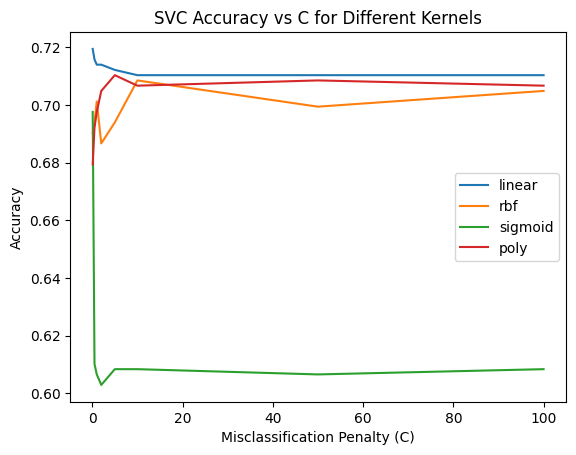

In [4]:
#Remove all NaN values
data_classification = data.dropna(subset = ['FastestFPLap',
                                            'MeanFPLaps',
                                            'StdFPLaps',
                                            'DeltaBestFPLap',
                                            'FasterThanTeammateFP',
                                            'PointFinishRace'
                                            ])

#Input values
X = data_classification[['FastestFPLap'
                        ,'MeanFPLaps',
                        'StdFPLaps',
                        'DeltaBestFPLap',
                        'FasterThanTeammateFP',
                        ]]

#Target value
y = data_classification['PointFinishRace'].astype(int)

#Test / train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = r_seed)

#Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Test models with differnt kernels
kernels = ['linear', 'rbf', 'sigmoid', 'poly']
cs = [0.1, 0.5, 1, 2, 5, 10, 50, 100]
results = []

for kernel in kernels:
    for c in cs:
        model = svm.SVC(kernel = kernel, C = c)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        results.append({'Kernel': kernel,
                        'C': c,
                        'Accuracy': accuracy
                        })

#Data frame for plotting
df_for_plotting = pd.DataFrame(results)

#Plot accuracy against complexity for each kernel
for kernel in df_for_plotting['Kernel'].unique():
    df = df_for_plotting[df_for_plotting['Kernel'] == kernel]
    plt.plot(df['C'], df['Accuracy'], label = kernel)

plt.legend()
plt.title('SVC Accuracy vs C for Different Kernels')
plt.ylabel('Accuracy')
plt.xlabel('Misclassification Penalty (C)')
plt.show()


In [5]:
# Find best result overall
best_row = df_for_plotting.loc[df_for_plotting['Accuracy'].idxmax()]
best_c = best_row['C']
best_acc = best_row['Accuracy']
best_kernel = best_row['Kernel']

print(f'Highest accuracy of {best_acc:.2f} with: Kernel = {best_kernel} and C = {best_c} ')

Highest accuracy of 0.72 with: Kernel = linear and C = 0.1 


In [6]:
#Training model with "best" values
model = svm.SVC(kernel = best_kernel, C = best_c)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"------------------- Kernel: {best_kernel} C = {best_c} -------------------")
print(classification_report(y_test, y_pred, target_names=["No Points", "Scored Points"]))

------------------- Kernel: linear C = 0.1 -------------------
               precision    recall  f1-score   support

    No Points       0.72      0.74      0.73       279
Scored Points       0.72      0.70      0.71       270

     accuracy                           0.72       549
    macro avg       0.72      0.72      0.72       549
 weighted avg       0.72      0.72      0.72       549



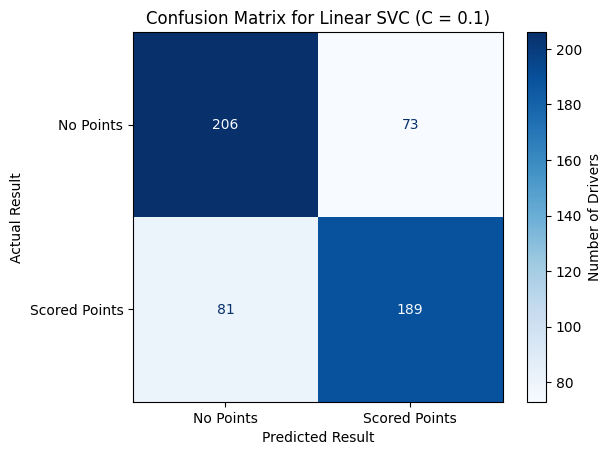

In [7]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Points", "Scored Points"])
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix for Linear SVC (C = {best_c})")
plt.xlabel("Predicted Result")
plt.ylabel("Actual Result")
cbar = disp.ax_.images[-1].colorbar
cbar.set_label("Number of Drivers")
plt.show()

## Task 2: Bayesian and Probabilistic Modeling

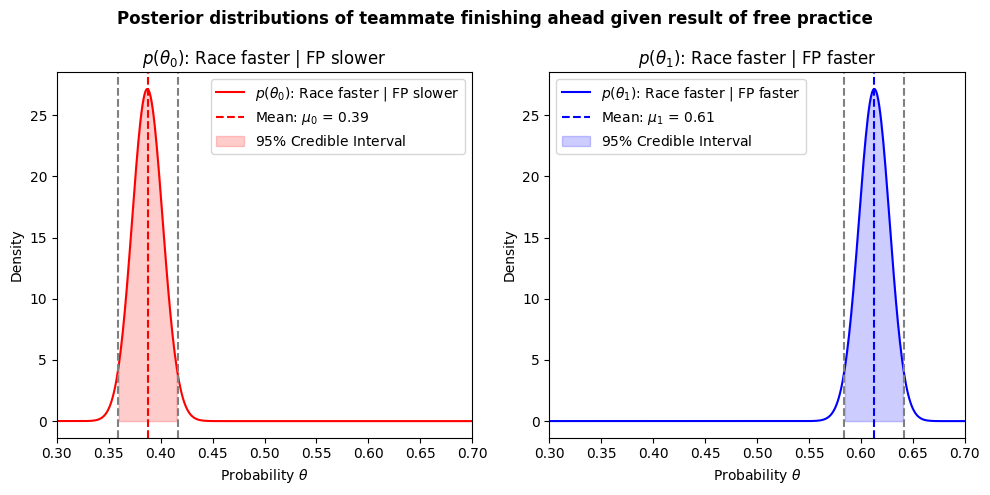

Prior: Beta(1, 1)
Prior mean: 0.50 (50.0%)

Race faster | FP faster
Posterior: Beta(674, 426)
Posterior mean: 0.61 (61.3%)

Race faster | FP slower
Posterior: Beta(426, 674)
Posterior mean: 0.39 (38.7%)


In [8]:
#Columns
fp_col = "FasterThanTeammateFP"
race_col = "FasterThanTeammateRace"

#Drop NaN values
data_bayesian = data[[fp_col, race_col]].dropna()

#Convert to int
fp = data_bayesian[fp_col].astype(int)
race = data_bayesian[race_col].astype(int)

#Prior belief
alpha_prior = 1
beta_prior  = 1
prior_mean  = alpha_prior / (alpha_prior + beta_prior)
theta = np.linspace(0, 1, 1000)
prior_pdf = stats.beta.pdf(theta, alpha_prior, beta_prior)

#Faster in race given faster in FP
idx_faster_fp = (fp == 1)
n_faster_in_race_fast_fp = race[idx_faster_fp].sum()
n_trails_faster_fp = fp.sum()

#Faster in race given slower in FP
idx_slower_fp = (fp == 0)
n_faster_in_race_slower_fp = race[idx_slower_fp].sum()
n_trails_slower_fp = fp.sum()

def beta_post(success, n_trails, alpha_prior, beta_prior, n_theta = 1000):
    alpha_post = alpha_prior + success
    beta_post = beta_prior + (n_trails - success)
    post_mean = alpha_post / (alpha_post + beta_post)

    ci_lower = stats.beta.ppf(0.025, alpha_post, beta_post)
    ci_upper = stats.beta.ppf(0.975, alpha_post, beta_post)

    theta = np.linspace(0, 1, n_theta)
    post_pdf = stats.beta.pdf(theta, alpha_post, beta_post)

    return ci_lower, ci_upper, post_pdf, alpha_post, beta_post, post_mean

# Grid for θ
theta = np.linspace(0, 1, 1000)

#Plotting
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
ci_l_0, ci_u_0, pdf0, alpha_p_0, beta_p_0, post_m_0 = beta_post(n_faster_in_race_slower_fp,
                                                                n_trails_slower_fp, alpha_prior,
                                                                beta_prior)
plt.plot(theta, pdf0, '-',label = r'$p(\theta_0)$: Race faster | FP slower', color = 'red')
plt.axvline(post_m_0, color='red', linestyle='--', label=rf'Mean: $\mu_0$ = {post_m_0:.2f}')
plt.axvline(ci_l_0, linestyle = '--', color = 'grey')
plt.axvline(ci_u_0, linestyle = '--', color = 'grey')
plt.fill_between(theta, pdf0, where=(theta >= ci_l_0) & (theta <= ci_u_0), alpha=0.2, color = 'red', label=r'$95\% \text{ Credible Interval}$')
plt.xlim([0.3, 0.7])
plt.xlabel(r'Probability $\theta$')
plt.ylabel('Density')
plt.title(r'$p(\theta_0)$: Race faster | FP slower')
plt.legend()

plt.subplot(1, 2, 2)
ci_l_1, ci_i_1, pdf1, alpha_p_1, beta_p_1, post_m_1 = beta_post(n_faster_in_race_fast_fp,
                                                                n_trails_faster_fp, alpha_prior,
                                                                beta_prior)
plt.plot(theta, pdf1, '-',label = r'$p(\theta_1)$: Race faster | FP faster', color = 'blue')
plt.axvline(post_m_1, color='blue', linestyle='--', label=rf'Mean: $\mu_1$ = {post_m_1:.2f}')
plt.axvline(ci_l_1, linestyle = '--', color = 'grey')
plt.axvline(ci_i_1, linestyle = '--', color = 'grey')
plt.fill_between(theta, pdf1, where=(theta >= ci_l_1) & (theta <= ci_i_1), alpha=0.2, color = 'blue', label=r'$95\% \text{ Credible Interval}$')
plt.xlim([0.3, 0.7])
plt.xlabel(r'Probability $\theta$')
plt.ylabel('Density')
plt.title(r'$p(\theta_1)$: Race faster | FP faster')
plt.legend()

plt.suptitle('Posterior distributions of teammate finishing ahead given result of free practice', fontweight='bold')
plt.tight_layout()
plt.show()

#Prior belief
print(f'Prior: Beta({alpha_prior}, {beta_prior})')
print(f'Prior mean: {prior_mean:.2f} ({prior_mean*100:.1f}%)')

#Posterior belief
print('\nRace faster | FP faster')
print(f'Posterior: Beta({alpha_p_1}, {beta_p_1})')
print(f'Posterior mean: {post_m_1:.2f} ({post_m_1*100:.1f}%)')

print('\nRace faster | FP slower')
print(f'Posterior: Beta({alpha_p_0}, {beta_p_0})')
print(f'Posterior mean: {post_m_0:.2f} ({post_m_0*100:.1f}%)')

# Predict fastest lap in the Race using Free Practice data

In [9]:
#Prepare data
data_fastest_lap_pred = data.dropna(subset = ['FastestFPLap',
                                              'MeanFPLaps',
                                              'StdFPLaps',
                                              'DeltaBestFPLap',
                                              'TrackTempAvgFP',
                                              'AirTempAvgFP',
                                              'RainAvgFP',
                                              'FastestLapRace',
                                              'TrackTempAvgRace',
                                              'AirTempAvgRace',
                                              'RainAvgRace'])
#Input values
features = ['FastestFPLap',
            'MeanFPLaps',
            'StdFPLaps',
            'DeltaBestFPLap',
            'TrackTempAvgFP',
            'AirTempAvgFP',
            'RainAvgFP']
X = data_fastest_lap_pred[features]

#Output values
y = data_fastest_lap_pred['FastestLapRace']

#Group for Cross Validation so that GPs are not split
groups = data_fastest_lap_pred['GP']

#Cross validation setup
alphas = np.logspace(-4, 4, 100)
cv = GroupKFold(n_splits = 5, shuffle = True, random_state = r_seed)

#Create pipelines
pipelines = {'Lasso': Pipeline([
                            ("scaler", StandardScaler()),
                            ("poly", PolynomialFeatures(degree = 1, include_bias=False)),
                            ("model", Lasso(max_iter = 50000))]),
        'Ridge': Pipeline([
                            ("scaler", StandardScaler()),
                            ("poly", PolynomialFeatures(degree = 1, include_bias=False)),
                            ("model", Ridge(max_iter = 50000))]),
        'ElasticNet': Pipeline([
                            ("scaler", StandardScaler()),
                            ("poly", PolynomialFeatures(degree = 1, include_bias=False)),
                            ("model", ElasticNet(max_iter = 50000))]),
        'ElasticNet (l1_ratio = 0.7)': Pipeline([
                            ("scaler", StandardScaler()),
                            ("poly", PolynomialFeatures(degree = 1, include_bias=False)),
                            ("model", ElasticNet(max_iter = 50000, l1_ratio = 0.7))])}

for name, pipeline in pipelines.items():
    print(f'------------------- Model: {name} ------------------- ')
    #Grid search for best alpha
    grid = GridSearchCV(
    estimator = pipeline,
    param_grid = {'model__alpha': alphas},
    cv = GroupKFold(n_splits = 5, shuffle = True, random_state = r_seed),
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1
    )

    #Fit model
    grid.fit(X, y, groups = groups)

    #Print out the best alpha
    print(f"Best α: {grid.best_params_['model__alpha']:.3f}")
    print(f"Best MAE: {-grid.best_score_:.3f}")

    #Evaluate with best alpha
    best_model = grid.best_estimator_

    #MAE and R^2 scores
    mae_scores = -cross_val_score(best_model, X, y, cv = cv, groups = groups, scoring = 'neg_mean_absolute_error')
    r2_scores  =  cross_val_score(best_model, X, y, cv = cv, groups = groups, scoring = 'r2')

    print(f"MAE: {mae_scores.mean():.3f} ± {mae_scores.std():.3f}")
    print(f"R²:  {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")


------------------- Model: Lasso ------------------- 
Best α: 0.142
Best MAE: 1.467
MAE: 1.561 ± 0.638
R²:  0.908 ± 0.099
------------------- Model: Ridge ------------------- 
Best α: 25.950
Best MAE: 1.453
MAE: 1.528 ± 0.281
R²:  0.909 ± 0.069
------------------- Model: ElasticNet ------------------- 
Best α: 0.013
Best MAE: 1.404
MAE: 1.419 ± 0.452
R²:  0.819 ± 0.153
------------------- Model: ElasticNet (l1_ratio = 0.7) ------------------- 
Best α: 0.022
Best MAE: 1.547
MAE: 1.488 ± 0.310
R²:  0.922 ± 0.055


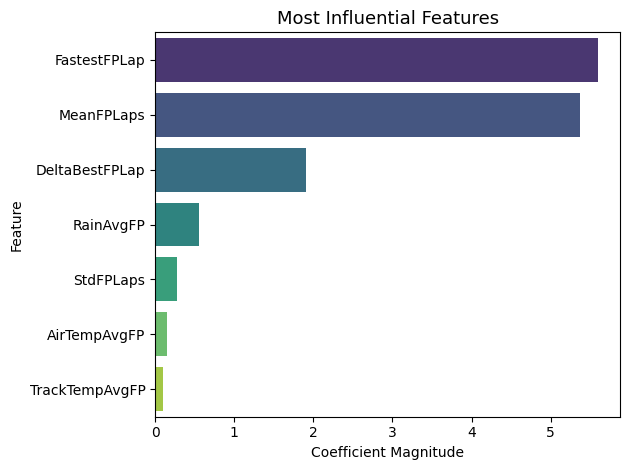

,Feature,Coefficient
0,FastestFPLap,5.595949
1,MeanFPLaps,5.370404
3,DeltaBestFPLap,1.903730
6,RainAvgFP,-0.556704
2,StdFPLaps,0.282066
5,AirTempAvgFP,0.144681
4,TrackTempAvgFP,-0.098998


In [54]:
# --- Extract coefficients and corresponding feature names ---
model = best_model.named_steps['model']
poly  = best_model.named_steps['poly']

coef_df = pd.DataFrame({
    "Feature": poly.get_feature_names_out(features),
    "Coefficient": model.coef_
})

# Sort by absolute importance
coef_df["AbsValue"] = coef_df["Coefficient"].abs()
coef_df = coef_df.sort_values(by="AbsValue", ascending=False).head(len(features))

# --- Plot ---
sns.barplot(
    data=coef_df,
    x="AbsValue", y="Feature",
    palette="viridis",
    hue = "Feature"
)

plt.title("Most Influential Features", fontsize=13)
plt.xlabel("Coefficient Magnitude")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Optional: display the numeric table below
display(coef_df[['Feature','Coefficient']])


                           GP   Predicted   Actual     Error
0       Australian Grand Prix   78.687287   82.167 -3.479713
1          Chinese Grand Prix   93.177712   95.069 -1.891288
2         Japanese Grand Prix   90.174823   90.965 -0.790177
3          Bahrain Grand Prix   91.564617   95.140 -3.575383
4    Saudi Arabian Grand Prix   89.810422   91.778 -1.967578
5            Miami Grand Prix   89.180678   89.746 -0.565322
6   Emilia Romagna Grand Prix   77.525530   77.988 -0.462470
7           Monaco Grand Prix   73.486485   73.221  0.265485
8          Spanish Grand Prix   73.759094   75.743 -1.983906
9         Canadian Grand Prix   74.532180   74.119  0.413180
10        Austrian Grand Prix   67.438145   67.924 -0.485855
11         British Grand Prix   87.671167   89.337 -1.665833
12         Belgian Grand Prix  102.606054  104.861 -2.254946
13       Hungarian Grand Prix   77.423097   79.409 -1.985903
14           Dutch Grand Prix   71.861203   72.271 -0.409797
15         Italian Grand

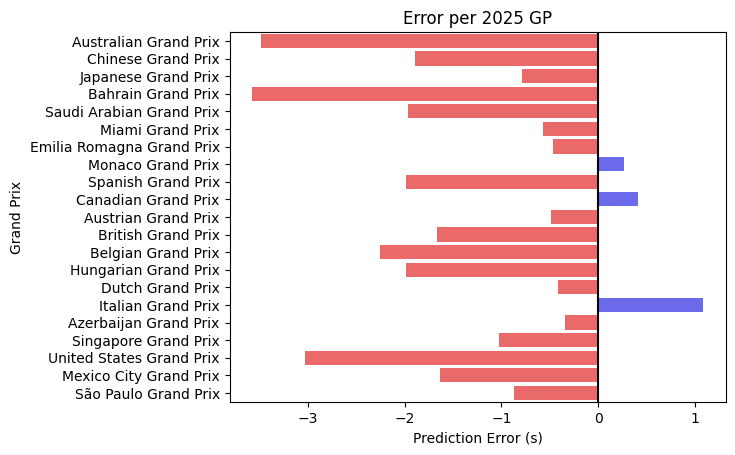

In [ ]:
# Load the 2025 dataset
data_2025 = pd.read_csv("F1_data_2025.csv")

# Feature list (same as training)
train_features = [
    "FastestFPLap",
    "MeanFPLaps",
    "StdFPLaps",
    "DeltaBestFPLap",
    "TrackTempAvgFP",
    "AirTempAvgFP",
    "RainAvgFP"
]

# Ensure no missing input features
data_2025 = data_2025.dropna(subset=train_features + ["FastestLapRace", "GP"])

# Collect predictions for all races
results = []

for gp_name in data_2025["GP"].unique():
    data_gp = data_2025[data_2025["GP"] == gp_name].copy()
    if data_gp.empty:
        continue

    # Ensure same columns and order as training
    X_gp = data_gp[train_features]
    y_real = data_gp["FastestLapRace"]

    # Predict using tuned Ridge pipeline
    y_pred = best_model.predict(X_gp)

    # Take the fastest (minimum) predicted and real laps
    predicted = np.min(y_pred)
    actual = np.min(y_real)
    error = predicted - actual

    results.append({
        "GP": gp_name,
        "Predicted": predicted,
        "Actual": actual,
        "Error": error
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

results_df["Sign"] = results_df["Error"].apply(lambda x: x < 0)

sns.barplot(x=results_df['Error'], y=results_df['GP'], palette='seismic', hue=results_df['Sign'], legend=False)
plt.axvline(0, color='black')
plt.xlabel("Prediction Error (s)")
plt.ylabel("Grand Prix")
plt.title("Error per 2025 GP")
plt.show()
